# Imports and utility

In [1]:
#d8f53b61969adf7ee621c216f680b707
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras_hub
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet152, EfficientNetB0, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import optimizers

train_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
val_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'
test_dir = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
auto_test = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/auto_test'
cat_dir = '/kaggle/input/cat-knee/clean'

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
SEED = 66


In [2]:
import pandas as pd
import os

def create_dataframe_from_directory(base_dir, regression=False):
    data = []
    for label_str in sorted(os.listdir(base_dir)):
        label_path = os.path.join(base_dir, label_str)
        if not os.path.isdir(label_path):
            continue
        label = float(label_str) if regression else label_str
        for fname in os.listdir(label_path):
            data.append({
                'filename': os.path.join(label_str, fname),  # ruta relativa
                'label': label  # KL debe ser numérico para regresión
            })
    return pd.DataFrame(data)

In [3]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
import tensorflow as tf

class CatValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, cat_generator, regresion=False, filepath='best_model_cat.keras'):
        super().__init__()
        self.cat_generator = cat_generator
        self.epoch_metrics = []
        self.regresion = regresion
        self.filepath = filepath
        # Inicializamos best_score y best_loss
        if regresion:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar MAE
        else:
            self.best_score = 0.0    # queremos maximizar accuracy
            self.best_loss  = np.inf # y minimizar categorical loss

    def on_epoch_end(self, epoch, logs=None):
        # Predicciones
        preds = self.model.predict(self.cat_generator, verbose=0)

        if self.regresion:
            # Regresión: calculamos MAE + accuracy sobre clases redondeadas
            y_pred = preds.flatten()
            y_true = self.cat_generator.labels
            loss = mean_absolute_error(y_true, y_pred)
            y_pred_class = np.clip(np.round(y_pred), 0, 4).astype(int)
            y_true_class = np.clip(np.round(y_true), 0, 4).astype(int)
            acc = accuracy_score(y_true_class, y_pred_class)
            score = acc
        else:
            # Clasificación: evalúa el loss y la accuracy
            loss, acc = self.model.evaluate(self.cat_generator, verbose=0)
            preds_class = np.argmax(preds, axis=1)
            y_true = self.cat_generator.classes
            # para consistency, recalculamos acc con sklearn
            acc = accuracy_score(y_true, preds_class)
            score = acc

        # Guardar métricas
        self.epoch_metrics.append({
            'epoch': epoch + 1,
            'val_cat_loss': loss,
            'val_cat_accuracy': acc
        })

        # Mostrar por consola
        tag = "MAE" if self.regresion else "Loss"
        print(f"🐾 [Cat Val] {tag}: {loss:.4f} | Accuracy: {acc:.4f}")

        # Comprobamos mejora: primero por score, si empate por loss
        improved = False
        if score > self.best_score:
            improved = True
        elif score == self.best_score and loss < self.best_loss:
            improved = True

        # Si mejoró, guardamos modelo y actualizamos referencias
        if improved:
            self.best_score = score
            self.best_loss  = loss
            self.model.save(self.filepath)
            print(f"📦 Modelo mejorado guardado en {self.filepath}")


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

def get_callbacks(regression=False, cat_gen=None):
  cat_val_cb = CatValidationCallback(cat_gen, regresion=regression)
  

  checkpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',         # nombre de la métrica a monitorizar
    mode='max',                     # porque buscamos la mayor precisión
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  checkpoint_cb_reg = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
  )
  if regression:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb_reg
    ]
  else:
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, verbose=1),
        cat_val_cb,
        checkpoint_cb
    ]
  return callbacks


In [5]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def _get_label_map(y_true, y_pred, generator=None, default_prefix='KL'):
    """
    Genera label_map automáticamente.
    - Si el generador tiene class_indices (clasificación Keras), los usa.
    - Si no, extrae las clases únicas de y_true y y_pred.
    - Si todo falla, crea labels 'KL 0', 'KL 1', ..., según número de clases.
    """
    # Caso Keras classification_generator
    if generator is not None and hasattr(generator, 'class_indices'):
        # Ordenar por índice
        sorted_items = sorted(generator.class_indices.items(), key=lambda x: x[1])
        return [name for name, _ in sorted_items]
    
    # Extraer clases únicas
    classes = np.unique(np.concatenate((y_true, y_pred)))
    # Si son enteros consecutivos desde 0 a n-1
    if np.array_equal(classes, np.arange(len(classes))):
        return [f'{default_prefix} {i}' for i in classes]
    # En caso de etiquetas no enteras o desordenadas
    return [str(c) for c in classes]

def evaluate_classification(y_true, y_pred, label_map=None, digits=4, title_suffix=''):
    """
    Reporte de clasificación + matriz de confusión.
    """
    if label_map is None:
        label_map = _get_label_map(y_true, y_pred)
    # Reporte
    print(classification_report(
        y_true, y_pred,
        target_names=label_map,
        digits=digits
    ))
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=label_map, yticklabels=label_map
    )
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta verdadera')
    if title_suffix:
        plt.title(title_suffix)
    plt.show()

def evaluate_model(model, regression, generator, label_map=None, digits=4):
    """
    Elige el modo de evaluación y asegura que label_map siempre se resuelva.
    """
    # Predicciones crudas
    preds = model.predict(generator)
    
    if regression:
        # Convertir a clases
        if hasattr(generator, 'labels'):
            y_true_cont = np.array(generator.labels).flatten()
        else:
            y_true_cont = np.array(generator.classes).flatten()
        y_pred_cont = np.array(preds).flatten()
        
        # MAE
        mae = mean_absolute_error(y_true_cont, y_pred_cont)
        print(f"Mean Absolute Error (MAE): {mae:.{digits}f}\n")
        plt.figure(figsize=(6,6))
        # Dispersión
        plt.scatter(y_pred_cont, y_true_cont, alpha=0.5)
        # Línea de identidad
        mn = min(y_true_cont.min(), y_pred_cont.min())
        mx = max(y_true_cont.max(), y_pred_cont.max())
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        # Etiquetas
        plt.xlabel("Predicción (decimal)")
        plt.ylabel("Valor verdadero")
        plt.title("Scatter: Predicción vs Valor verdadero")
        plt.grid(True)
        plt.show()

        y_true_class = np.clip(np.round(y_true_cont).astype(int), 0, None)
        y_pred_class = np.clip(np.round(y_pred_cont).astype(int), 0, None)
        # Obtener label_map adaptado al rango observado
        if label_map is None:
            max_label = max(y_true_class.max(), y_pred_class.max())
            label_map = [f'KL {i}' for i in range(max_label + 1)]
        
        evaluate_classification(
            y_true=y_true_class,
            y_pred=y_pred_class,
            label_map=label_map,
            digits=digits,
        )
    else:
        # Clasificación softmax u otra salida multiclase
        y_pred = np.argmax(preds, axis=1)
        y_true = generator.classes
        
        if label_map is None:
            label_map = _get_label_map(y_true, y_pred, generator=generator)
        
        evaluate_classification(
            y_true=y_true,
            y_pred=y_pred,
            label_map=label_map,
            digits=digits
        )


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def get_datagen(
    tarea: int,
    path: str,
    regression: bool = False,
    IMG_SIZE: tuple = (224, 224),
    BATCH_SIZE: int = 32,
    SEED: int = 42,
    augment: bool = False
):
    """
    Generador de imágenes para clasificación y regresión con distintos esquemas de tarea.

    Parámetros:
        tarea       – entero 0–5 que define esquema de etiquetas.
        path        – ruta al directorio de imágenes (train/val/test u otro).
        regression  – True para regresión (class_mode='raw'), False para clasificación.
        IMG_SIZE    – tupla (alto, ancho).
        BATCH_SIZE  – tamaño de lote.
        SEED        – semilla aleatoria.
        augment     – True para data augmentation (solo en entrenamiento).
    """
    # Configurar DataGenerator
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )
        shuffle = True
    else:
        datagen = ImageDataGenerator(rescale=1./255)
        shuffle = False

    # Cargar dataframe con tu función; label como float si regresión, str si clasificación
    df = create_dataframe_from_directory(path, regression=regression)
    # Clasificación: convertir labels a ints para procesar tareas
    df_proc = df.copy()
    df_proc['label'] = df_proc['label'].astype(int)

    if tarea == 0:
        # Multiclase original 0–4: no cambio
        pass
    elif tarea == 1:
        df_proc['label'] = df_proc['label'].apply(
            lambda x: 0 if x in [0,1,2] else 1 if x == 3 else 2 if x == 4 else x
        )
    elif tarea in [2,3,4,5]:
        target = tarea - 1  # tarea=2->1, etc.
        df_proc = df_proc[df_proc['label'].isin([0, target])]
        df_proc['label'] = df_proc['label'].apply(lambda x: 1 if x == target else 0)
    else:
        raise ValueError("tarea debe ser un entero entre 0 y 5.")

    if regression:
        # Asegurar float
        df_proc['label'] = df_proc['label'].astype(float)
        df_proc['label'] = (df_proc['label'] - df_proc['label'].min()) / (df_proc['label'].max() - df_proc['label'].min())
        return datagen.flow_from_dataframe(
            dataframe=df_proc,
            directory=path,
            x_col='filename',
            y_col='label',
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='raw',
            shuffle=shuffle,
            seed=SEED
        )
    # Convertir a string para class_mode='categorical'
    df_proc['label'] = df_proc['label'].astype(str)
    
    # Generador de clasificación
    return datagen.flow_from_dataframe(
        dataframe=df_proc,
        directory=path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        seed=SEED
    )


## Experimentos a realizar

Normal 
012-3-4
0-1
0-2
0-3
0-4

In [7]:
def cnn_pequeno(num_classes = 5, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu',
                      input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(num_classes, activation=activation)
    ])
    return model

In [8]:
def cnn_mediana(num_classes, regression=False):
    activation = 'linear' if regression else 'softmax'
    model = models.Sequential([
        # Primera capa convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPooling2D((2, 2)),
        # Segunda capa convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Aplanamiento y capas densas
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation=activation)
    ])
    return model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    Flatten, Dense
)

def cnn_grande(num_classes, regression = False):
    activation = 'linear' if regression else 'softmax'
    model = Sequential(name="CNN_Profunda")

    # Bloque 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Bloque 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.40))

    # Clasificación final
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))

    return model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, BatchNormalization,
    Dropout, Dense
)
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7

def efficientnetB0_model(num_classes, regression=False):
    """
    Modelo basado en EfficientNetB0 con cabeza personalizada.
    - Input: 224×224×3
    - Preentrenado en ImageNet
    - Arquitectura secuencial
    """
    activation = 'linear' if regression else 'softmax'
    # Cargamos la base EfficientNetB0 sin la capa superior
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    model = Sequential(name="EfficientNetB0_Custom")
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))
    return model

def efficientnetB7_model(num_classes, regression=False):
    """
    Modelo basado en EfficientNetB7 con cabeza personalizada.
    - Input: 600×600×3 (recomendado para B7)
    - Preentrenado en ImageNet
    - Arquitectura secuencial
    """
    activation = 'linear' if regression else 'softmax'
    base = EfficientNetB7(
        include_top=False,
        weights='imagenet',
        input_shape=(600, 600, 3)
    )
    model = Sequential(name="EfficientNetB7_Custom")
    model.add(base)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation=activation))
    return model


In [11]:
def simple_transformer(num_classes=5, regression=False):
    activation = 'linear' if regression else 'softmax'

    inputs = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.Reshape((-1, 32))(x)
    x = layers.MultiHeadAttention(num_heads=1, key_dim=4)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation=activation)(x)

    model = models.Model(inputs, outputs)
    return model

Found 5778 validated image filenames.
Found 826 validated image filenames.
Found 83 validated image filenames.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - loss: 3.0562 - mae: 1.3388🐾 [Cat Val] MAE: 28.8399 | Accuracy: 0.0000
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_loss improved from inf to 917.77759, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 224s 837ms/step - loss: 3.0507 - mae: 1.3373 - val_loss: 917.7776 - val_mae: 30.2926 - learning_rate: 0.0010
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 0.7462 - mae: 0.6349🐾 [Cat Val] MAE: 12.8233 | Accuracy: 0.3855
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 2: val_loss improved from 917.77759 to 32.69348, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 70s 372ms/step - loss: 0.7454 - mae: 0.6345 - val_loss: 32.6935 - val_mae: 4.6015 - learning_rate: 0.0010
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - loss: 0.2936 - mae: 0.3922🐾 [Cat Val] MAE: 2.5025 | Accuracy: 0.2048

Epoch 3: val_loss did not improve from 32.69348
181/181 ━━━━━━━━━━━━━━━━━━━━ 68s 359m

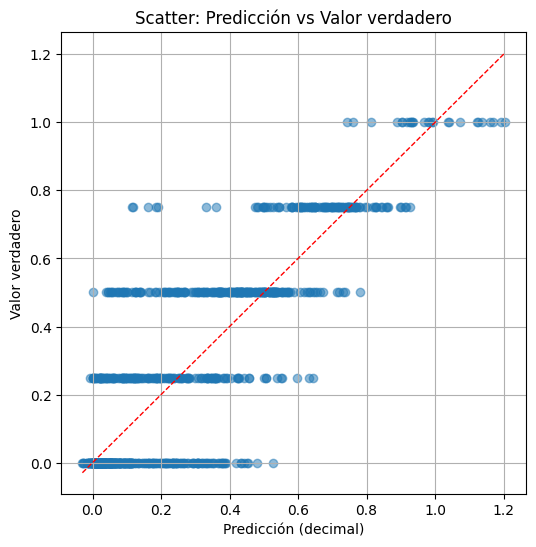

              precision    recall  f1-score   support

        KL 0     0.9813    0.9076    0.9430       693
        KL 1     0.6541    0.9098    0.7610       133

    accuracy                         0.9080       826
   macro avg     0.8177    0.9087    0.8520       826
weighted avg     0.9286    0.9080    0.9137       826



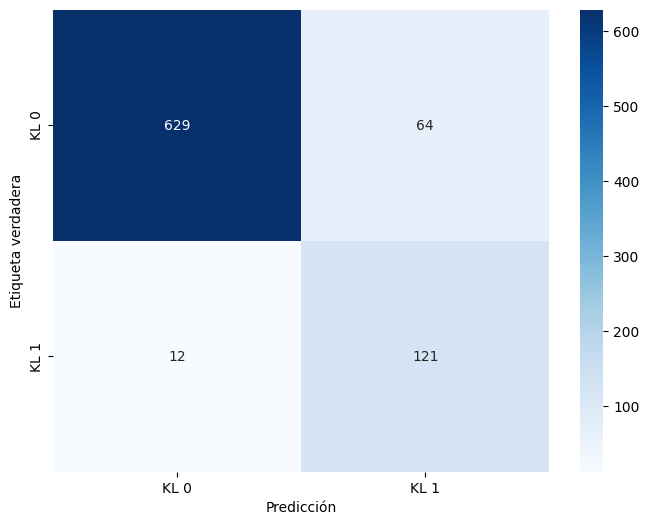

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Mean Absolute Error (MAE): 0.2226



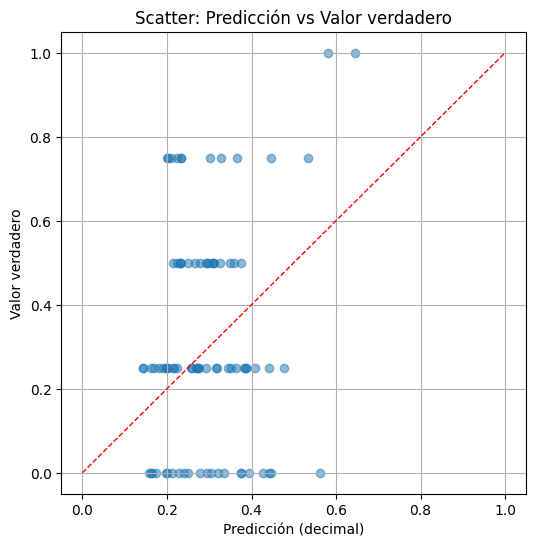

              precision    recall  f1-score   support

        KL 0     0.8734    0.9857    0.9262        70
        KL 1     0.7500    0.2308    0.3529        13

    accuracy                         0.8675        83
   macro avg     0.8117    0.6082    0.6396        83
weighted avg     0.8541    0.8675    0.8364        83



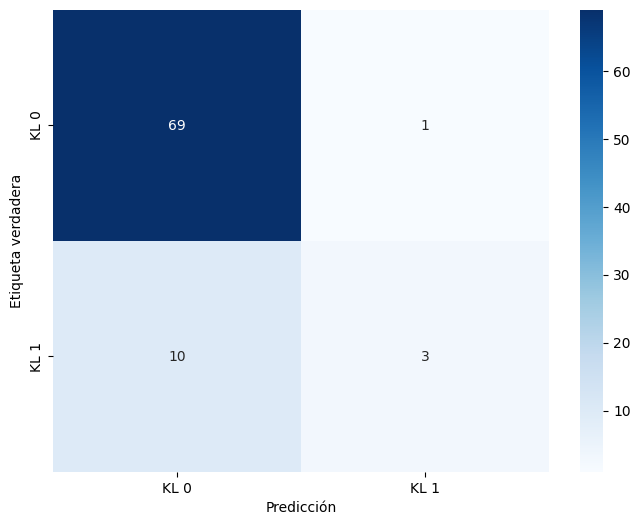

In [12]:
regression = True
tarea = 0
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

Found 5778 validated image filenames.
Found 826 validated image filenames.
Found 83 validated image filenames.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 3.2445 - mae: 1.3484🐾 [Cat Val] MAE: 19.0391 | Accuracy: 0.0000
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 1: val_loss improved from inf to 910.19891, saving model to best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 177s 636ms/step - loss: 3.2384 - mae: 1.3468 - val_loss: 910.1989 - val_mae: 30.0445 - learning_rate: 0.0010
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 0.8544 - mae: 0.6073🐾 [Cat Val] MAE: 23.5804 | Accuracy: 0.0723
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 2: val_loss did not improve from 910.19891
181/181 ━━━━━━━━━━━━━━━━━━━━ 71s 378ms/step - loss: 0.8536 - mae: 0.6069 - val_loss: 1244.6681 - val_mae: 28.8734 - learning_rate: 0.0010
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.3453 - mae: 0.3735🐾 [Cat Val] MAE: 1.4494 | Accuracy: 0.7952
📦 Modelo mejorado guardado en best_model_cat.keras

Epoch 3: val_loss did not improve from 910.19891
181/181 ━━━━━━━━━━━━━

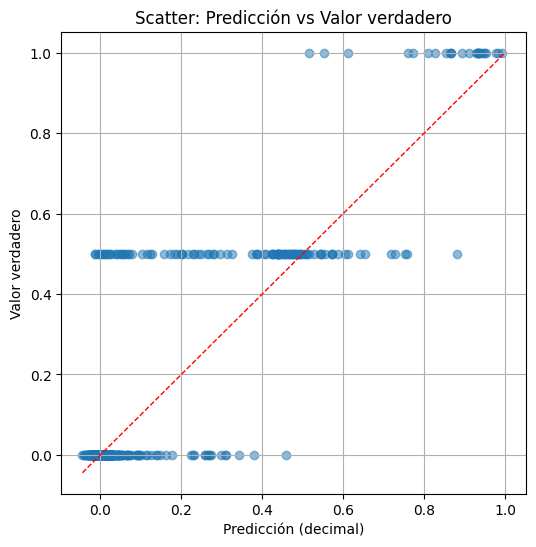

              precision    recall  f1-score   support

        KL 0     1.0000    0.9725    0.9860       799
        KL 1     0.5510    1.0000    0.7105        27

    accuracy                         0.9734       826
   macro avg     0.7755    0.9862    0.8483       826
weighted avg     0.9853    0.9734    0.9770       826



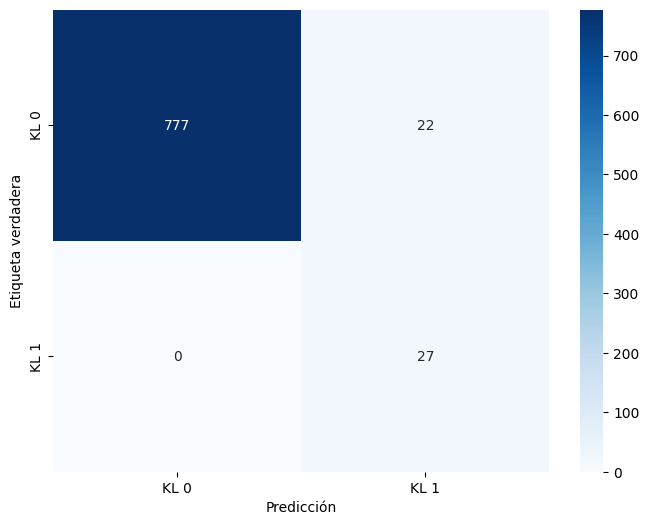

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Mean Absolute Error (MAE): 0.2642



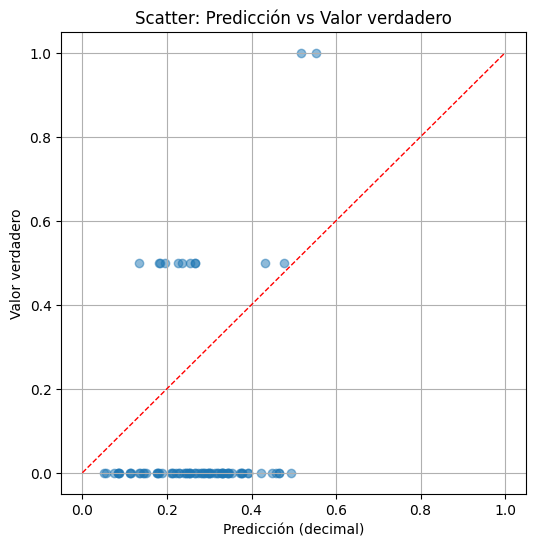

              precision    recall  f1-score   support

        KL 0     1.0000    1.0000    1.0000        81
        KL 1     1.0000    1.0000    1.0000         2

    accuracy                         1.0000        83
   macro avg     1.0000    1.0000    1.0000        83
weighted avg     1.0000    1.0000    1.0000        83



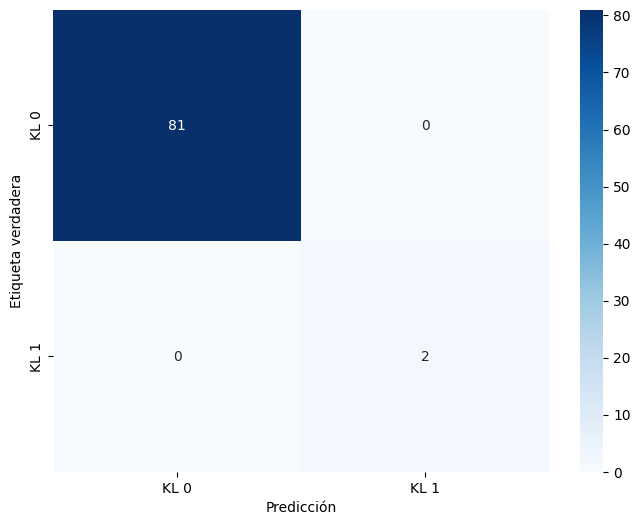

In [13]:
regression = True
tarea = 1
batch_size = 32
num_classes = 5
if regression:
    num_classes = 1
elif tarea == 1:
    num_classes = 3
elif tarea > 1:
    num_classes = 2

loss = 'mean_squared_error' if regression else 'categorical_crossentropy'
metrics = ['mae'] if regression else ['accuracy']

# Generadores de datos (entrenamiento y validación)
train_gen = get_datagen(tarea=tarea, path=train_dir, regression=regression, BATCH_SIZE=batch_size, augment=True)
val_gen   = get_datagen(tarea=tarea, path=val_dir,  BATCH_SIZE=batch_size, regression=regression)
cat_gen = get_datagen(tarea=tarea, path=cat_dir, BATCH_SIZE=batch_size, regression=regression)


model = efficientnetB0_model(num_classes, regression)
model.compile(optimizer='adam',
                  loss=loss,
                  metrics=metrics)
callbacks=get_callbacks(regression, cat_gen)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

model.load_weights('best_model.keras')
# Obtén el diccionario original {etiqueta_str: índice_entero}
evaluate_model(model, regression=regression, generator=val_gen)
model.load_weights('best_model_cat.keras')
evaluate_model(model, regression=regression, generator=cat_gen)

=== Historial de entrenamiento ===
loss: [2.131730079650879, 0.7068198323249817, 0.29707226157188416, 0.16272833943367004, 0.11989646404981613, 0.0851828008890152, 0.05918348208069801, 0.04747255519032478, 0.038882285356521606, 0.032906871289014816, 0.02725655771791935, 0.02608443796634674, 0.024130914360284805, 0.022311287000775337, 0.02153465710580349, 0.020881474018096924, 0.02118656598031521, 0.019385768100619316, 0.02022378146648407, 0.01969313807785511, 0.0180836021900177, 0.01885411888360977, 0.018911665305495262, 0.017414802685379982, 0.01886838674545288, 0.01718967594206333, 0.017273910343647003, 0.018120821565389633, 0.017214305698871613, 0.01608406938612461, 0.015344983898103237, 0.015786774456501007, 0.015366779640316963, 0.015585721470415592, 0.012614819221198559, 0.012326338328421116, 0.012571434490382671, 0.011890512891113758, 0.011775057762861252, 0.011533592827618122, 0.011698172427713871, 0.011658091098070145, 0.009793841280043125, 0.008804181590676308, 0.009739528410

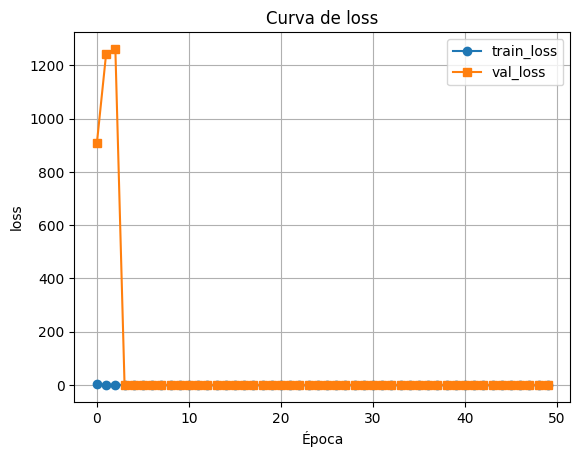

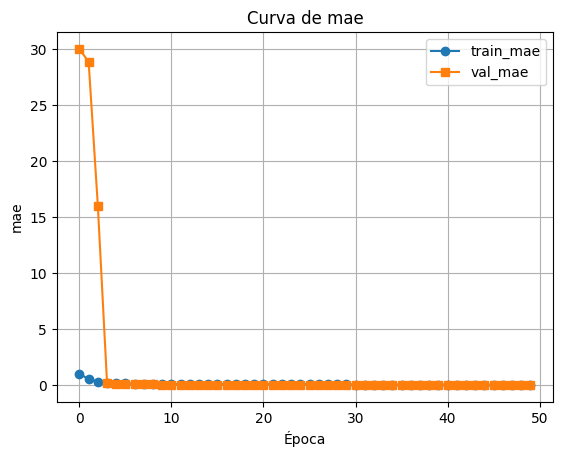

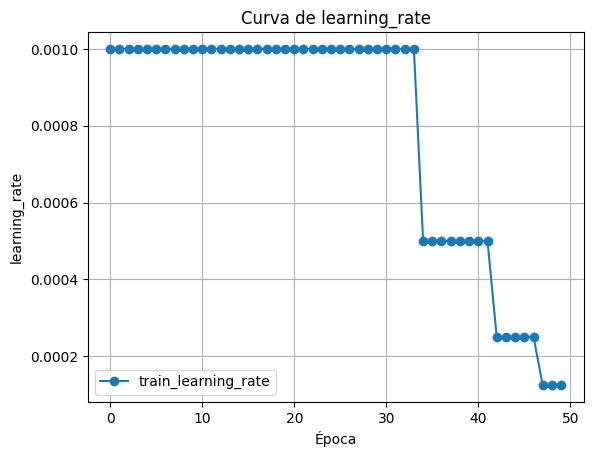

In [14]:
print("=== Historial de entrenamiento ===")
for metric_name, metric_values in history.history.items():
    print(f"{metric_name}: {metric_values}")

# 2. (Opcional) Graficar las curvas de entrenamiento y validación
import matplotlib.pyplot as plt

# Determinar qué métricas hay (loss, mae o accuracy, val_loss, val_mae o val_accuracy)
keys = list(history.history.keys())

# Para cada métrica de entrenamiento sin prefijo 'val_'
for k in keys:
    if not k.startswith('val_'):
        plt.figure()
        plt.plot(history.history[k], marker='o', label=f'train_{k}')
        val_key = f'val_{k}'
        if val_key in history.history:
            plt.plot(history.history[val_key], marker='s', label=f'val_{k}')
        plt.title(f'Curva de {k}')
        plt.xlabel('Época')
        plt.ylabel(k)
        plt.legend()
        plt.grid(True)
        plt.show()

=== Historial de validación de gatos ===
Época 1: Loss/MAE = 19.0391, Accuracy = 0.0000
Época 2: Loss/MAE = 23.5804, Accuracy = 0.0723
Época 3: Loss/MAE = 1.4494, Accuracy = 0.7952
Época 4: Loss/MAE = 0.1603, Accuracy = 0.9759
Época 5: Loss/MAE = 0.2187, Accuracy = 0.9759
Época 6: Loss/MAE = 0.2460, Accuracy = 0.9759
Época 7: Loss/MAE = 0.2203, Accuracy = 0.9759
Época 8: Loss/MAE = 0.2811, Accuracy = 0.9518
Época 9: Loss/MAE = 0.2457, Accuracy = 0.9880
Época 10: Loss/MAE = 0.2078, Accuracy = 0.9880
Época 11: Loss/MAE = 0.1982, Accuracy = 0.9880
Época 12: Loss/MAE = 0.1504, Accuracy = 0.9880
Época 13: Loss/MAE = 0.1657, Accuracy = 0.9880
Época 14: Loss/MAE = 0.1907, Accuracy = 0.9880
Época 15: Loss/MAE = 0.2124, Accuracy = 0.9880
Época 16: Loss/MAE = 0.1865, Accuracy = 0.9880
Época 17: Loss/MAE = 0.2892, Accuracy = 0.8434
Época 18: Loss/MAE = 0.1962, Accuracy = 0.9880
Época 19: Loss/MAE = 0.2068, Accuracy = 0.9880
Época 20: Loss/MAE = 0.1822, Accuracy = 0.9880
Época 21: Loss/MAE = 0.307

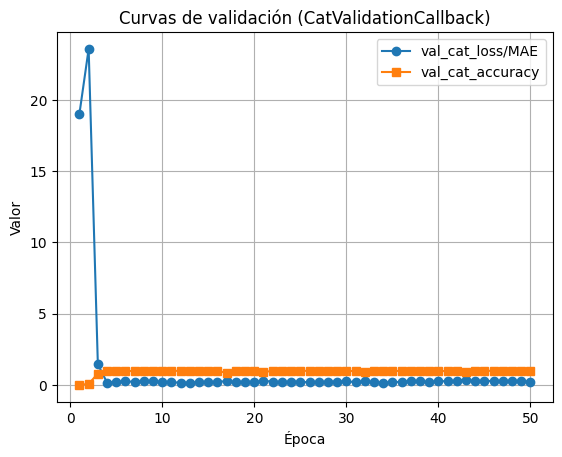

In [15]:
cat_callback = callbacks[2]

print("=== Historial de validación de gatos ===")
for m in cat_callback.epoch_metrics:
    epoch = m['epoch']
    loss = m['val_cat_loss']
    acc  = m['val_cat_accuracy']
    print(f"Época {epoch}: Loss/MAE = {loss:.4f}, Accuracy = {acc:.4f}")

# (Opcional) Graficar la evolución de loss y accuracy de validación de gatos
import matplotlib.pyplot as plt

epochs = [m['epoch'] for m in cat_callback.epoch_metrics]
losses = [m['val_cat_loss'] for m in cat_callback.epoch_metrics]
accs   = [m['val_cat_accuracy'] for m in cat_callback.epoch_metrics]

plt.figure()
plt.plot(epochs, losses, marker='o', label='val_cat_loss/MAE')
plt.plot(epochs, accs,   marker='s', label='val_cat_accuracy')
plt.title('Curvas de validación (CatValidationCallback)')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# Anterior

## Exploración del dataset de artrosis de rodilla

- **Total de imágenes:** 9 786

| Partición      | Imágenes | Porcentaje |
|---------------|---------:|-----------:|
| **Train**      | 5 778    | 59.04 %    |
| **Validation** |   826    |  8.44 %    |
| **Test**       | 1 656    | 16.92 %    |
| **AutoTest**   | 1 526    | 15.59 %    |


### Distribución de clases en `Train`

|  Clase  | Índice | Imágenes | Porcentaje |
|---------|-------:|---------:|-----------:|
| Sin     |      0 |    2 286 |     39.56 % |
| Ligera  |      1 |    1 046 |     18.10 % |
| Leve    |      2 |    1 516 |     26.24 % |
| Moderada|      3 |      757 |     13.10 % |
| Severa  |      4 |      173 |      2.99 % |

